In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import math
import sys

import numpy as np
import torch.utils.data as data

from tqdm import  tqdm
import matplotlib.pyplot as plt

In [2]:
input_length = 10
input_dim = 1
num_classes = 10
num_hidden = 128
batch_size = 128
learning_rate = 0.001
train_steps = 100
max_norm = 10.0
max_epochs = 150

In [3]:
class PalindromeDataset(data.Dataset):

    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        # Number of possible palindroms can be very big:
        # (10**(seq_length/2) or (10**((seq_length+1)/2)
        # Therefore we return the maximum integer value
        return sys.maxsize

    def __getitem__(self, idx):
        # Keep last digit as target label. Note: one-hot encoding for inputs is
        # more suitable for training, but this also works.
        full_palindrome = self.generate_palindrome()
        # Split palindrome into inputs (N-1 digits) and target (1 digit)
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        # Generates a single, random palindrome number of 'length' digits.
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length/2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))

In [4]:
class VanillaRNN(nn.Module):

    def __init__(self, seq_length, input_dim, hidden_dim, output_dim, batch_size):
        super(VanillaRNN, self).__init__()
        # Initialization here ...
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.w_x2h = nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True)
        self.w_h2h = nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=False)
        self.w_h2o = nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)
        self.tanh = nn.Tanh()


    def forward(self, inputs, state=None):
        # Implementation here ...
        
        inputs = torch.t(inputs)
        
        if state is None:
            state = torch.zeros([self.batch_size, self.hidden_dim],device=inputs.device)
        else:
            state = state
        
        outputs = []
        for x in inputs:
            x = torch.unsqueeze(x, dim=1)
            # print("x", x.shape, x)
            
            state = self.tanh(self.w_x2h(x) + self.w_h2h(state))
        out = self.w_h2o(state)
        return out
        
    # add more methods here if needed

In [5]:
def train(input_length, max_epochs, eval_freq):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
    print("start training RNN...")
    print(device)

    # Initialize the model that we are going to use
    model = VanillaRNN(seq_length=input_length, input_dim=input_dim, hidden_dim=num_hidden, output_dim=num_classes,
                       batch_size=batch_size)
    
    model.to(device)

    # Initialize the dataset and data loader (leave the +1)
    dataset = PalindromeDataset(input_length+1)
    train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4)
    test_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4)

    # Setup the loss and optimizer
    cost = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(max_epochs)):
        
        model.train()
        
        train_acc_avg = 0.
        train_loss_avg = 0.
        
        for idx, (input, target) in enumerate(train_loader):
            
            input, target = input.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(input)
            loss = cost(output, target)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            loss.backward()
            optimizer.step()
            
            
            train_loss_avg += loss.item()
            
            _, id = torch.max(output.data, 1)
            train_acc_avg += torch.sum(id == target.data)/target.shape[0]
            
            if idx == train_steps:
                break
            
        if epoch % eval_freq == 0:
            
            test_acc_avg = 0.
            test_loss_avg = 0.
            
            with torch.no_grad():
                for idx, (input, target) in enumerate(test_loader):
                    
                    input, target = input.to(device), target.to(device)
                    
                    output = model(input)
                    loss = cost(output, target)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
                    
                    test_loss_avg += loss.item()
                    
                    _, id = torch.max(output.data, 1)
                    test_acc_avg += torch.sum(id == target.data)/target.shape[0]
                    
                    if idx == train_steps:
                        break
                
                epoch_list.append(epoch)
                
                train_loss_avg = train_loss_avg/(train_steps+1)
                loss_train_list.append(train_loss_avg)
                
                test_loss_avg = test_loss_avg/(train_steps+1)
                loss_test_list.append(test_loss_avg)
                
                train_acc_avg = train_acc_avg/(train_steps+1)
                acc_train_list.append(train_acc_avg)
                
                test_acc_avg = test_acc_avg/(train_steps+1)
                acc_test_list.append(test_acc_avg)
                
                print('TRAIN epoch: %d, loss : %lf, ACC: %lf' %(epoch, train_loss_avg, train_acc_avg))
                print('TEST epoch: %d, loss : %lf, ACC: %lf' %(epoch, test_loss_avg, test_acc_avg))
    
    return model

In [6]:
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
epoch_list = []
model = train(input_length=3, max_epochs=50, eval_freq=1)

start training RNN...
cuda:0


  2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

TRAIN epoch: 0, loss : 1.148813, ACC: 0.608601
TEST epoch: 0, loss : 0.658752, ACC: 0.842590


  4%|▍         | 2/50 [00:02<01:01,  1.29s/it]

TRAIN epoch: 1, loss : 0.488755, ACC: 0.885752
TEST epoch: 1, loss : 0.404556, ACC: 0.851485


  6%|▌         | 3/50 [00:03<00:59,  1.26s/it]

TRAIN epoch: 2, loss : 0.271597, ACC: 0.952197
TEST epoch: 2, loss : 0.178362, ACC: 0.991337


  8%|▊         | 4/50 [00:05<00:57,  1.25s/it]

TRAIN epoch: 3, loss : 0.147857, ACC: 0.980739
TEST epoch: 3, loss : 0.131076, ACC: 0.983369


 10%|█         | 5/50 [00:06<00:56,  1.26s/it]

TRAIN epoch: 4, loss : 0.084215, ACC: 0.988165
TEST epoch: 4, loss : 0.047216, ACC: 1.000000


 12%|█▏        | 6/50 [00:07<00:55,  1.25s/it]

TRAIN epoch: 5, loss : 0.033546, ACC: 1.000000
TEST epoch: 5, loss : 0.023789, ACC: 1.000000


 14%|█▍        | 7/50 [00:08<00:54,  1.26s/it]

TRAIN epoch: 6, loss : 0.016991, ACC: 1.000000
TEST epoch: 6, loss : 0.012192, ACC: 1.000000


 16%|█▌        | 8/50 [00:10<00:52,  1.25s/it]

TRAIN epoch: 7, loss : 0.008847, ACC: 1.000000
TEST epoch: 7, loss : 0.006449, ACC: 1.000000


 18%|█▊        | 9/50 [00:11<00:50,  1.24s/it]

TRAIN epoch: 8, loss : 0.004750, ACC: 1.000000
TEST epoch: 8, loss : 0.003506, ACC: 1.000000


 20%|██        | 10/50 [00:12<00:49,  1.23s/it]

TRAIN epoch: 9, loss : 0.002616, ACC: 1.000000
TEST epoch: 9, loss : 0.001952, ACC: 1.000000


 22%|██▏       | 11/50 [00:13<00:48,  1.23s/it]

TRAIN epoch: 10, loss : 0.001471, ACC: 1.000000
TEST epoch: 10, loss : 0.001107, ACC: 1.000000


 24%|██▍       | 12/50 [00:14<00:46,  1.23s/it]

TRAIN epoch: 11, loss : 0.000841, ACC: 1.000000
TEST epoch: 11, loss : 0.000637, ACC: 1.000000


 26%|██▌       | 13/50 [00:16<00:44,  1.22s/it]

TRAIN epoch: 12, loss : 0.000487, ACC: 1.000000
TEST epoch: 12, loss : 0.000371, ACC: 1.000000


 28%|██▊       | 14/50 [00:17<00:43,  1.22s/it]

TRAIN epoch: 13, loss : 0.000286, ACC: 1.000000
TEST epoch: 13, loss : 0.000219, ACC: 1.000000


 30%|███       | 15/50 [00:18<00:43,  1.23s/it]

TRAIN epoch: 14, loss : 0.000169, ACC: 1.000000
TEST epoch: 14, loss : 0.000130, ACC: 1.000000


 32%|███▏      | 16/50 [00:19<00:41,  1.23s/it]

TRAIN epoch: 15, loss : 0.000100, ACC: 1.000000
TEST epoch: 15, loss : 0.000077, ACC: 1.000000


 34%|███▍      | 17/50 [00:21<00:40,  1.23s/it]

TRAIN epoch: 16, loss : 0.000060, ACC: 1.000000
TEST epoch: 16, loss : 0.000046, ACC: 1.000000


 36%|███▌      | 18/50 [00:22<00:39,  1.23s/it]

TRAIN epoch: 17, loss : 0.000036, ACC: 1.000000
TEST epoch: 17, loss : 0.000028, ACC: 1.000000


 38%|███▊      | 19/50 [00:23<00:37,  1.22s/it]

TRAIN epoch: 18, loss : 0.000022, ACC: 1.000000
TEST epoch: 18, loss : 0.000017, ACC: 1.000000


 40%|████      | 20/50 [00:24<00:36,  1.22s/it]

TRAIN epoch: 19, loss : 0.000013, ACC: 1.000000
TEST epoch: 19, loss : 0.000010, ACC: 1.000000


 42%|████▏     | 21/50 [00:25<00:35,  1.22s/it]

TRAIN epoch: 20, loss : 0.000008, ACC: 1.000000
TEST epoch: 20, loss : 0.000006, ACC: 1.000000


 44%|████▍     | 22/50 [00:27<00:34,  1.22s/it]

TRAIN epoch: 21, loss : 0.000005, ACC: 1.000000
TEST epoch: 21, loss : 0.000004, ACC: 1.000000


 46%|████▌     | 23/50 [00:28<00:32,  1.22s/it]

TRAIN epoch: 22, loss : 0.000003, ACC: 1.000000
TEST epoch: 22, loss : 0.000002, ACC: 1.000000


 48%|████▊     | 24/50 [00:29<00:31,  1.21s/it]

TRAIN epoch: 23, loss : 0.000002, ACC: 1.000000
TEST epoch: 23, loss : 0.000001, ACC: 1.000000


 50%|█████     | 25/50 [00:30<00:30,  1.22s/it]

TRAIN epoch: 24, loss : 0.000001, ACC: 1.000000
TEST epoch: 24, loss : 0.000001, ACC: 1.000000


 52%|█████▏    | 26/50 [00:32<00:29,  1.22s/it]

TRAIN epoch: 25, loss : 0.000001, ACC: 1.000000
TEST epoch: 25, loss : 0.000000, ACC: 1.000000


 54%|█████▍    | 27/50 [00:33<00:27,  1.21s/it]

TRAIN epoch: 26, loss : 0.000000, ACC: 1.000000
TEST epoch: 26, loss : 0.000000, ACC: 1.000000


 56%|█████▌    | 28/50 [00:34<00:26,  1.22s/it]

TRAIN epoch: 27, loss : 0.000000, ACC: 1.000000
TEST epoch: 27, loss : 0.000000, ACC: 1.000000


 58%|█████▊    | 29/50 [00:35<00:25,  1.21s/it]

TRAIN epoch: 28, loss : 0.000000, ACC: 1.000000
TEST epoch: 28, loss : 0.000000, ACC: 1.000000


 60%|██████    | 30/50 [00:36<00:24,  1.23s/it]

TRAIN epoch: 29, loss : 0.000000, ACC: 1.000000
TEST epoch: 29, loss : 0.000000, ACC: 1.000000


 62%|██████▏   | 31/50 [00:38<00:23,  1.24s/it]

TRAIN epoch: 30, loss : 0.000000, ACC: 1.000000
TEST epoch: 30, loss : 0.000000, ACC: 1.000000


 64%|██████▍   | 32/50 [00:39<00:22,  1.25s/it]

TRAIN epoch: 31, loss : 0.000000, ACC: 1.000000
TEST epoch: 31, loss : 0.000000, ACC: 1.000000


 66%|██████▌   | 33/50 [00:40<00:21,  1.26s/it]

TRAIN epoch: 32, loss : 0.000000, ACC: 1.000000
TEST epoch: 32, loss : 0.000000, ACC: 1.000000


 68%|██████▊   | 34/50 [00:42<00:20,  1.26s/it]

TRAIN epoch: 33, loss : 0.000000, ACC: 1.000000
TEST epoch: 33, loss : 0.000000, ACC: 1.000000


 70%|███████   | 35/50 [00:43<00:18,  1.24s/it]

TRAIN epoch: 34, loss : 0.000000, ACC: 1.000000
TEST epoch: 34, loss : 0.000000, ACC: 1.000000


 72%|███████▏  | 36/50 [00:44<00:17,  1.24s/it]

TRAIN epoch: 35, loss : 0.000000, ACC: 1.000000
TEST epoch: 35, loss : 0.000000, ACC: 1.000000


 74%|███████▍  | 37/50 [00:45<00:15,  1.23s/it]

TRAIN epoch: 36, loss : 0.177744, ACC: 0.987469
TEST epoch: 36, loss : 3.101456, ACC: 0.687191


 76%|███████▌  | 38/50 [00:46<00:14,  1.22s/it]

TRAIN epoch: 37, loss : 0.039989, ACC: 0.995514
TEST epoch: 37, loss : 0.000135, ACC: 1.000000


 78%|███████▊  | 39/50 [00:48<00:13,  1.22s/it]

TRAIN epoch: 38, loss : 0.000094, ACC: 1.000000
TEST epoch: 38, loss : 0.000066, ACC: 1.000000


 80%|████████  | 40/50 [00:49<00:12,  1.22s/it]

TRAIN epoch: 39, loss : 0.000051, ACC: 1.000000
TEST epoch: 39, loss : 0.000039, ACC: 1.000000


 82%|████████▏ | 41/50 [00:50<00:11,  1.22s/it]

TRAIN epoch: 40, loss : 0.000032, ACC: 1.000000
TEST epoch: 40, loss : 0.000025, ACC: 1.000000


 84%|████████▍ | 42/50 [00:51<00:09,  1.21s/it]

TRAIN epoch: 41, loss : 0.000021, ACC: 1.000000
TEST epoch: 41, loss : 0.000017, ACC: 1.000000


 86%|████████▌ | 43/50 [00:52<00:08,  1.20s/it]

TRAIN epoch: 42, loss : 0.000014, ACC: 1.000000
TEST epoch: 42, loss : 0.000011, ACC: 1.000000


 88%|████████▊ | 44/50 [00:54<00:07,  1.20s/it]

TRAIN epoch: 43, loss : 0.000009, ACC: 1.000000
TEST epoch: 43, loss : 0.000008, ACC: 1.000000


 90%|█████████ | 45/50 [00:55<00:06,  1.21s/it]

TRAIN epoch: 44, loss : 0.000006, ACC: 1.000000
TEST epoch: 44, loss : 0.000005, ACC: 1.000000


 92%|█████████▏| 46/50 [00:56<00:04,  1.21s/it]

TRAIN epoch: 45, loss : 0.000004, ACC: 1.000000
TEST epoch: 45, loss : 0.000004, ACC: 1.000000


 94%|█████████▍| 47/50 [00:57<00:03,  1.22s/it]

TRAIN epoch: 46, loss : 0.000003, ACC: 1.000000
TEST epoch: 46, loss : 0.000002, ACC: 1.000000


 96%|█████████▌| 48/50 [00:58<00:02,  1.21s/it]

TRAIN epoch: 47, loss : 0.000002, ACC: 1.000000
TEST epoch: 47, loss : 0.000002, ACC: 1.000000


 98%|█████████▊| 49/50 [01:00<00:01,  1.21s/it]

TRAIN epoch: 48, loss : 0.000001, ACC: 1.000000
TEST epoch: 48, loss : 0.000001, ACC: 1.000000


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]

TRAIN epoch: 49, loss : 0.000001, ACC: 1.000000
TEST epoch: 49, loss : 0.000001, ACC: 1.000000


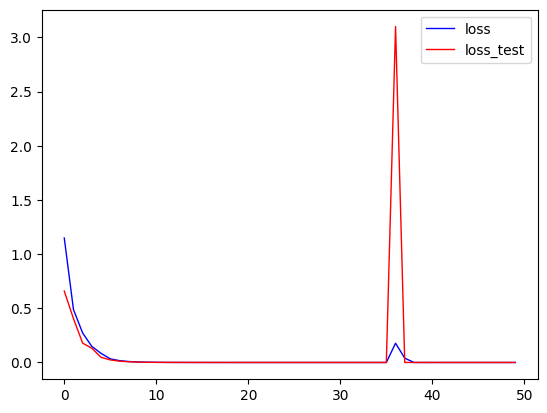

In [7]:
plt.plot(epoch_list, loss_train_list, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, loss_test_list, linewidth=1, color="red",label="loss_test")
plt.legend()

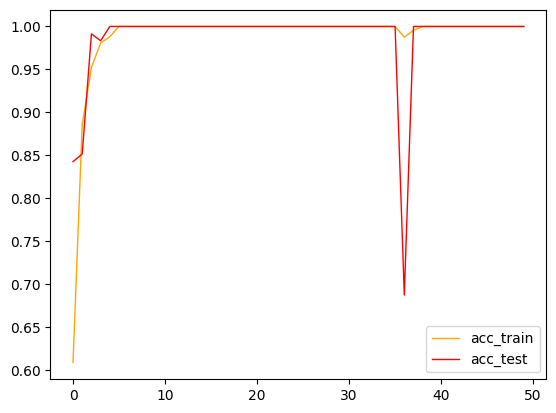

In [8]:
plt.plot(epoch_list, acc_train_list, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_list, acc_test_list, linewidth=1, color="red",label="acc_test")
plt.legend()

In [9]:
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
epoch_list = []
model = train(input_length=5, max_epochs=50, eval_freq=1)

start training RNN...
cuda:0


  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

TRAIN epoch: 0, loss : 1.623522, ACC: 0.398747
TEST epoch: 0, loss : 1.058889, ACC: 0.659189


  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

TRAIN epoch: 1, loss : 0.775953, ACC: 0.751779
TEST epoch: 1, loss : 0.501100, ACC: 0.909189


  6%|▌         | 3/50 [00:04<01:02,  1.33s/it]

TRAIN epoch: 2, loss : 0.416779, ACC: 0.884127
TEST epoch: 2, loss : 0.258617, ACC: 0.964573


  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

TRAIN epoch: 3, loss : 0.239775, ACC: 0.943069
TEST epoch: 3, loss : 0.139435, ACC: 0.997525


 10%|█         | 5/50 [00:06<00:59,  1.32s/it]

TRAIN epoch: 4, loss : 0.110490, ACC: 0.988088
TEST epoch: 4, loss : 0.058982, ACC: 1.000000


 12%|█▏        | 6/50 [00:07<00:58,  1.33s/it]

TRAIN epoch: 5, loss : 0.040560, ACC: 1.000000
TEST epoch: 5, loss : 0.026787, ACC: 1.000000


 14%|█▍        | 7/50 [00:09<00:56,  1.33s/it]

TRAIN epoch: 6, loss : 0.018462, ACC: 1.000000
TEST epoch: 6, loss : 0.012494, ACC: 1.000000


 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

TRAIN epoch: 7, loss : 0.008735, ACC: 1.000000
TEST epoch: 7, loss : 0.006073, ACC: 1.000000


 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

TRAIN epoch: 8, loss : 0.004364, ACC: 1.000000
TEST epoch: 8, loss : 0.003119, ACC: 1.000000


 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

TRAIN epoch: 9, loss : 0.002285, ACC: 1.000000
TEST epoch: 9, loss : 0.001650, ACC: 1.000000


 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

TRAIN epoch: 10, loss : 0.001227, ACC: 1.000000
TEST epoch: 10, loss : 0.000897, ACC: 1.000000


 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

TRAIN epoch: 11, loss : 0.000671, ACC: 1.000000
TEST epoch: 11, loss : 0.000493, ACC: 1.000000


 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

TRAIN epoch: 12, loss : 0.000370, ACC: 1.000000
TEST epoch: 12, loss : 0.000275, ACC: 1.000000


 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

TRAIN epoch: 13, loss : 0.000209, ACC: 1.000000
TEST epoch: 13, loss : 0.000157, ACC: 1.000000


 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

TRAIN epoch: 14, loss : 0.000120, ACC: 1.000000
TEST epoch: 14, loss : 0.000090, ACC: 1.000000


 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

TRAIN epoch: 15, loss : 0.000069, ACC: 1.000000
TEST epoch: 15, loss : 0.000053, ACC: 1.000000


 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

TRAIN epoch: 16, loss : 0.000041, ACC: 1.000000
TEST epoch: 16, loss : 0.000031, ACC: 1.000000


 36%|███▌      | 18/50 [00:23<00:42,  1.32s/it]

TRAIN epoch: 17, loss : 0.000024, ACC: 1.000000
TEST epoch: 17, loss : 0.000018, ACC: 1.000000


 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

TRAIN epoch: 18, loss : 0.000014, ACC: 1.000000
TEST epoch: 18, loss : 0.000011, ACC: 1.000000


 40%|████      | 20/50 [00:26<00:39,  1.32s/it]

TRAIN epoch: 19, loss : 0.000008, ACC: 1.000000
TEST epoch: 19, loss : 0.000006, ACC: 1.000000


 42%|████▏     | 21/50 [00:27<00:38,  1.33s/it]

TRAIN epoch: 20, loss : 0.000005, ACC: 1.000000
TEST epoch: 20, loss : 0.000004, ACC: 1.000000


 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

TRAIN epoch: 21, loss : 0.000003, ACC: 1.000000
TEST epoch: 21, loss : 0.000002, ACC: 1.000000


 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

TRAIN epoch: 22, loss : 0.000002, ACC: 1.000000
TEST epoch: 22, loss : 0.000001, ACC: 1.000000


 48%|████▊     | 24/50 [00:31<00:34,  1.32s/it]

TRAIN epoch: 23, loss : 0.000001, ACC: 1.000000
TEST epoch: 23, loss : 0.000001, ACC: 1.000000


 50%|█████     | 25/50 [00:33<00:32,  1.32s/it]

TRAIN epoch: 24, loss : 0.000001, ACC: 1.000000
TEST epoch: 24, loss : 0.000000, ACC: 1.000000


 52%|█████▏    | 26/50 [00:34<00:31,  1.31s/it]

TRAIN epoch: 25, loss : 0.000000, ACC: 1.000000
TEST epoch: 25, loss : 0.000000, ACC: 1.000000


 54%|█████▍    | 27/50 [00:35<00:30,  1.31s/it]

TRAIN epoch: 26, loss : 0.000000, ACC: 1.000000
TEST epoch: 26, loss : 0.000000, ACC: 1.000000


 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

TRAIN epoch: 27, loss : 0.000000, ACC: 1.000000
TEST epoch: 27, loss : 0.000000, ACC: 1.000000


 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

TRAIN epoch: 28, loss : 0.000000, ACC: 1.000000
TEST epoch: 28, loss : 0.000000, ACC: 1.000000


 60%|██████    | 30/50 [00:39<00:26,  1.34s/it]

TRAIN epoch: 29, loss : 0.000000, ACC: 1.000000
TEST epoch: 29, loss : 0.000000, ACC: 1.000000


 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

TRAIN epoch: 30, loss : 0.000000, ACC: 1.000000
TEST epoch: 30, loss : 0.000000, ACC: 1.000000


 64%|██████▍   | 32/50 [00:42<00:24,  1.35s/it]

TRAIN epoch: 31, loss : 0.000000, ACC: 1.000000
TEST epoch: 31, loss : 0.000000, ACC: 1.000000


 66%|██████▌   | 33/50 [00:43<00:22,  1.35s/it]

TRAIN epoch: 32, loss : 0.000000, ACC: 1.000000
TEST epoch: 32, loss : 0.000000, ACC: 1.000000


 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

TRAIN epoch: 33, loss : 0.000000, ACC: 1.000000
TEST epoch: 33, loss : 0.000000, ACC: 1.000000


 70%|███████   | 35/50 [00:46<00:20,  1.35s/it]

TRAIN epoch: 34, loss : 0.000000, ACC: 1.000000
TEST epoch: 34, loss : 0.000000, ACC: 1.000000


 72%|███████▏  | 36/50 [00:47<00:18,  1.34s/it]

TRAIN epoch: 35, loss : 0.360249, ACC: 0.953125
TEST epoch: 35, loss : 0.006781, ACC: 1.000000


 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

TRAIN epoch: 36, loss : 0.002685, ACC: 1.000000
TEST epoch: 36, loss : 0.001043, ACC: 1.000000


 76%|███████▌  | 38/50 [00:50<00:16,  1.34s/it]

TRAIN epoch: 37, loss : 0.000620, ACC: 1.000000
TEST epoch: 37, loss : 0.000374, ACC: 1.000000


 78%|███████▊  | 39/50 [00:51<00:14,  1.33s/it]

TRAIN epoch: 38, loss : 0.000255, ACC: 1.000000
TEST epoch: 38, loss : 0.000173, ACC: 1.000000


 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

TRAIN epoch: 39, loss : 0.000127, ACC: 1.000000
TEST epoch: 39, loss : 0.000093, ACC: 1.000000


 82%|████████▏ | 41/50 [00:54<00:11,  1.33s/it]

TRAIN epoch: 40, loss : 0.000071, ACC: 1.000000
TEST epoch: 40, loss : 0.000053, ACC: 1.000000


 84%|████████▍ | 42/50 [00:55<00:10,  1.33s/it]

TRAIN epoch: 41, loss : 0.000041, ACC: 1.000000
TEST epoch: 41, loss : 0.000031, ACC: 1.000000


 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

TRAIN epoch: 42, loss : 0.000024, ACC: 1.000000
TEST epoch: 42, loss : 0.000018, ACC: 1.000000


 88%|████████▊ | 44/50 [00:58<00:07,  1.32s/it]

TRAIN epoch: 43, loss : 0.000014, ACC: 1.000000
TEST epoch: 43, loss : 0.000010, ACC: 1.000000


 90%|█████████ | 45/50 [00:59<00:06,  1.32s/it]

TRAIN epoch: 44, loss : 0.000007, ACC: 1.000000
TEST epoch: 44, loss : 0.000005, ACC: 1.000000


 92%|█████████▏| 46/50 [01:01<00:05,  1.32s/it]

TRAIN epoch: 45, loss : 0.000004, ACC: 1.000000
TEST epoch: 45, loss : 0.000003, ACC: 1.000000


 94%|█████████▍| 47/50 [01:02<00:03,  1.32s/it]

TRAIN epoch: 46, loss : 0.000002, ACC: 1.000000
TEST epoch: 46, loss : 0.000002, ACC: 1.000000


 96%|█████████▌| 48/50 [01:03<00:02,  1.32s/it]

TRAIN epoch: 47, loss : 0.000001, ACC: 1.000000
TEST epoch: 47, loss : 0.000001, ACC: 1.000000


 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

TRAIN epoch: 48, loss : 0.000001, ACC: 1.000000
TEST epoch: 48, loss : 0.000001, ACC: 1.000000


100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

TRAIN epoch: 49, loss : 0.000001, ACC: 1.000000
TEST epoch: 49, loss : 0.000001, ACC: 1.000000


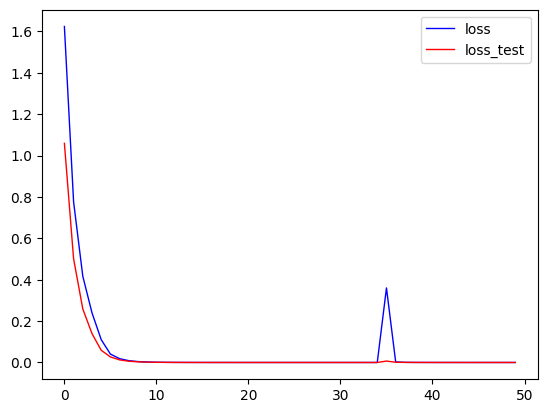

In [10]:
plt.plot(epoch_list, loss_train_list, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, loss_test_list, linewidth=1, color="red",label="loss_test")
plt.legend()

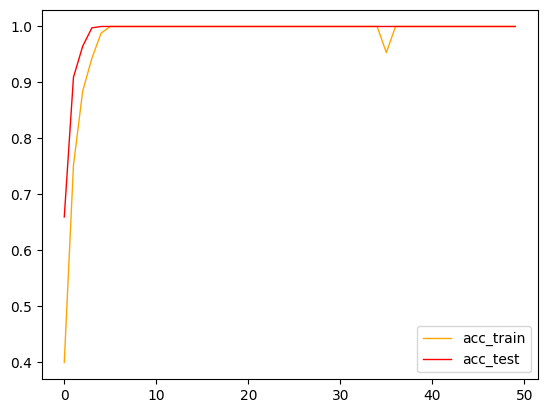

In [11]:
plt.plot(epoch_list, acc_train_list, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_list, acc_test_list, linewidth=1, color="red",label="acc_test")
plt.legend()

In [12]:
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
epoch_list = []
model = train(input_length=7, max_epochs=50, eval_freq=1)

start training RNN...
cuda:0


  2%|▏         | 1/50 [00:01<01:11,  1.45s/it]

TRAIN epoch: 0, loss : 2.009393, ACC: 0.250387
TEST epoch: 0, loss : 1.497959, ACC: 0.396426


  4%|▍         | 2/50 [00:02<01:08,  1.43s/it]

TRAIN epoch: 1, loss : 1.217056, ACC: 0.548035
TEST epoch: 1, loss : 1.003096, ACC: 0.596535


  6%|▌         | 3/50 [00:04<01:07,  1.43s/it]

TRAIN epoch: 2, loss : 0.847045, ACC: 0.678218
TEST epoch: 2, loss : 0.681699, ACC: 0.762840


  8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

TRAIN epoch: 3, loss : 0.628514, ACC: 0.755337
TEST epoch: 3, loss : 0.502752, ACC: 0.853264


 10%|█         | 5/50 [00:07<01:05,  1.44s/it]

TRAIN epoch: 4, loss : 0.491446, ACC: 0.808400
TEST epoch: 4, loss : 0.368708, ACC: 0.888072


 12%|█▏        | 6/50 [00:08<01:03,  1.45s/it]

TRAIN epoch: 5, loss : 0.391673, ACC: 0.862624
TEST epoch: 5, loss : 0.287623, ACC: 0.908338


 14%|█▍        | 7/50 [00:10<01:01,  1.44s/it]

TRAIN epoch: 6, loss : 0.324849, ACC: 0.887608
TEST epoch: 6, loss : 0.192233, ACC: 0.989093


 16%|█▌        | 8/50 [00:11<01:00,  1.44s/it]

TRAIN epoch: 7, loss : 0.221248, ACC: 0.940594
TEST epoch: 7, loss : 0.116441, ACC: 1.000000


 18%|█▊        | 9/50 [00:12<00:58,  1.43s/it]

TRAIN epoch: 8, loss : 0.185316, ACC: 0.963567
TEST epoch: 8, loss : 1.479881, ACC: 0.442373


 20%|██        | 10/50 [00:14<00:56,  1.42s/it]

TRAIN epoch: 9, loss : 0.108112, ACC: 0.984684
TEST epoch: 9, loss : 0.051609, ACC: 1.000000


 22%|██▏       | 11/50 [00:15<00:55,  1.42s/it]

TRAIN epoch: 10, loss : 0.039549, ACC: 1.000000
TEST epoch: 10, loss : 0.030686, ACC: 1.000000


 24%|██▍       | 12/50 [00:17<00:53,  1.41s/it]

TRAIN epoch: 11, loss : 0.231684, ACC: 0.949025
TEST epoch: 11, loss : 0.041003, ACC: 0.999691


 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

TRAIN epoch: 12, loss : 0.025103, ACC: 1.000000
TEST epoch: 12, loss : 0.019357, ACC: 1.000000


 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

TRAIN epoch: 13, loss : 0.016074, ACC: 1.000000
TEST epoch: 13, loss : 0.013475, ACC: 1.000000


 30%|███       | 15/50 [00:21<00:48,  1.39s/it]

TRAIN epoch: 14, loss : 0.105511, ACC: 0.985922
TEST epoch: 14, loss : 1.488862, ACC: 0.715347


 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

TRAIN epoch: 15, loss : 0.242028, ACC: 0.946395
TEST epoch: 15, loss : 2.814358, ACC: 0.350093


 34%|███▍      | 17/50 [00:24<00:46,  1.40s/it]

TRAIN epoch: 16, loss : 0.068433, ACC: 0.987237
TEST epoch: 16, loss : 0.013019, ACC: 1.000000


 36%|███▌      | 18/50 [00:25<00:45,  1.41s/it]

TRAIN epoch: 17, loss : 0.010836, ACC: 1.000000
TEST epoch: 17, loss : 0.009239, ACC: 1.000000


 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

TRAIN epoch: 18, loss : 0.007936, ACC: 1.000000
TEST epoch: 18, loss : 0.006866, ACC: 1.000000


 40%|████      | 20/50 [00:28<00:42,  1.42s/it]

TRAIN epoch: 19, loss : 0.005814, ACC: 1.000000
TEST epoch: 19, loss : 0.004944, ACC: 1.000000


 42%|████▏     | 21/50 [00:29<00:41,  1.41s/it]

TRAIN epoch: 20, loss : 0.004085, ACC: 1.000000
TEST epoch: 20, loss : 0.003388, ACC: 1.000000


 44%|████▍     | 22/50 [00:31<00:40,  1.43s/it]

TRAIN epoch: 21, loss : 0.002729, ACC: 1.000000
TEST epoch: 21, loss : 0.002205, ACC: 1.000000


 46%|████▌     | 23/50 [00:32<00:38,  1.44s/it]

TRAIN epoch: 22, loss : 0.001741, ACC: 1.000000
TEST epoch: 22, loss : 0.001380, ACC: 1.000000


 48%|████▊     | 24/50 [00:34<00:37,  1.44s/it]

TRAIN epoch: 23, loss : 0.001077, ACC: 1.000000
TEST epoch: 23, loss : 0.000842, ACC: 1.000000


 50%|█████     | 25/50 [00:35<00:35,  1.42s/it]

TRAIN epoch: 24, loss : 0.000649, ACC: 1.000000
TEST epoch: 24, loss : 0.000502, ACC: 1.000000


 52%|█████▏    | 26/50 [00:37<00:34,  1.44s/it]

TRAIN epoch: 25, loss : 0.000385, ACC: 1.000000
TEST epoch: 25, loss : 0.000296, ACC: 1.000000


 54%|█████▍    | 27/50 [00:38<00:32,  1.43s/it]

TRAIN epoch: 26, loss : 0.000228, ACC: 1.000000
TEST epoch: 26, loss : 0.000176, ACC: 1.000000


 56%|█████▌    | 28/50 [00:39<00:31,  1.42s/it]

TRAIN epoch: 27, loss : 0.000136, ACC: 1.000000
TEST epoch: 27, loss : 0.000105, ACC: 1.000000


 58%|█████▊    | 29/50 [00:41<00:29,  1.43s/it]

TRAIN epoch: 28, loss : 0.000081, ACC: 1.000000
TEST epoch: 28, loss : 0.000063, ACC: 1.000000


 60%|██████    | 30/50 [00:42<00:28,  1.44s/it]

TRAIN epoch: 29, loss : 0.000049, ACC: 1.000000
TEST epoch: 29, loss : 0.000038, ACC: 1.000000


 62%|██████▏   | 31/50 [00:44<00:27,  1.43s/it]

TRAIN epoch: 30, loss : 0.000029, ACC: 1.000000
TEST epoch: 30, loss : 0.000023, ACC: 1.000000


 64%|██████▍   | 32/50 [00:45<00:25,  1.43s/it]

TRAIN epoch: 31, loss : 0.000018, ACC: 1.000000
TEST epoch: 31, loss : 0.000014, ACC: 1.000000


 66%|██████▌   | 33/50 [00:46<00:24,  1.42s/it]

TRAIN epoch: 32, loss : 0.000011, ACC: 1.000000
TEST epoch: 32, loss : 0.000008, ACC: 1.000000


 68%|██████▊   | 34/50 [00:48<00:22,  1.42s/it]

TRAIN epoch: 33, loss : 0.000006, ACC: 1.000000
TEST epoch: 33, loss : 0.000005, ACC: 1.000000


 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

TRAIN epoch: 34, loss : 0.000004, ACC: 1.000000
TEST epoch: 34, loss : 0.000003, ACC: 1.000000


 72%|███████▏  | 36/50 [00:51<00:19,  1.42s/it]

TRAIN epoch: 35, loss : 0.000002, ACC: 1.000000
TEST epoch: 35, loss : 0.000002, ACC: 1.000000


 74%|███████▍  | 37/50 [00:52<00:18,  1.42s/it]

TRAIN epoch: 36, loss : 0.000001, ACC: 1.000000
TEST epoch: 36, loss : 0.000001, ACC: 1.000000


 76%|███████▌  | 38/50 [00:54<00:16,  1.41s/it]

TRAIN epoch: 37, loss : 0.833851, ACC: 0.824025
TEST epoch: 37, loss : 0.357288, ACC: 0.792466


 78%|███████▊  | 39/50 [00:55<00:15,  1.42s/it]

TRAIN epoch: 38, loss : 0.406224, ACC: 0.854657
TEST epoch: 38, loss : 0.348413, ACC: 0.843363


 80%|████████  | 40/50 [00:56<00:14,  1.43s/it]

TRAIN epoch: 39, loss : 0.053907, ACC: 0.991259
TEST epoch: 39, loss : 0.012222, ACC: 1.000000


 82%|████████▏ | 41/50 [00:58<00:13,  1.45s/it]

TRAIN epoch: 40, loss : 0.008188, ACC: 1.000000
TEST epoch: 40, loss : 0.004872, ACC: 1.000000


 84%|████████▍ | 42/50 [00:59<00:11,  1.46s/it]

TRAIN epoch: 41, loss : 0.002757, ACC: 1.000000
TEST epoch: 41, loss : 0.001960, ACC: 1.000000


 86%|████████▌ | 43/50 [01:01<00:10,  1.46s/it]

TRAIN epoch: 42, loss : 0.001532, ACC: 1.000000
TEST epoch: 42, loss : 0.001183, ACC: 1.000000


 88%|████████▊ | 44/50 [01:02<00:08,  1.44s/it]

TRAIN epoch: 43, loss : 0.000824, ACC: 1.000000
TEST epoch: 43, loss : 0.000570, ACC: 1.000000


 90%|█████████ | 45/50 [01:04<00:07,  1.44s/it]

TRAIN epoch: 44, loss : 0.000388, ACC: 1.000000
TEST epoch: 44, loss : 0.000279, ACC: 1.000000


 92%|█████████▏| 46/50 [01:05<00:05,  1.43s/it]

TRAIN epoch: 45, loss : 0.000212, ACC: 1.000000
TEST epoch: 45, loss : 0.000162, ACC: 1.000000


 94%|█████████▍| 47/50 [01:07<00:04,  1.43s/it]

TRAIN epoch: 46, loss : 0.000112, ACC: 1.000000
TEST epoch: 46, loss : 0.000085, ACC: 1.000000


 96%|█████████▌| 48/50 [01:08<00:02,  1.43s/it]

TRAIN epoch: 47, loss : 0.000057, ACC: 1.000000
TEST epoch: 47, loss : 0.000044, ACC: 1.000000


 98%|█████████▊| 49/50 [01:09<00:01,  1.42s/it]

TRAIN epoch: 48, loss : 0.000035, ACC: 1.000000
TEST epoch: 48, loss : 0.000029, ACC: 1.000000


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]

TRAIN epoch: 49, loss : 0.000024, ACC: 1.000000
TEST epoch: 49, loss : 0.000020, ACC: 1.000000


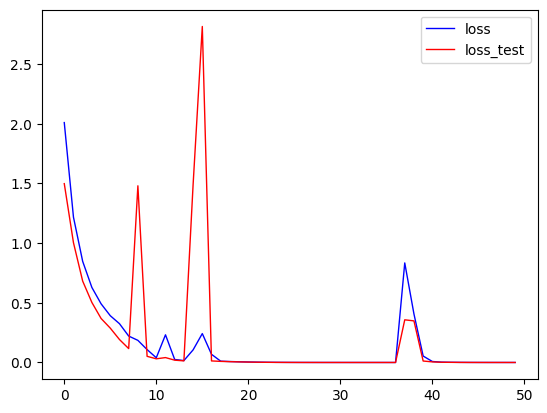

In [13]:
plt.plot(epoch_list, loss_train_list, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, loss_test_list, linewidth=1, color="red",label="loss_test")
plt.legend()

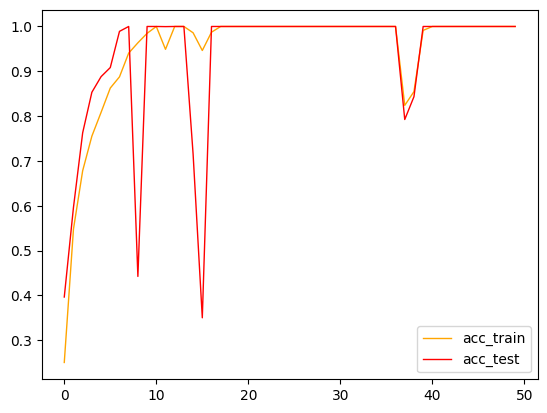

In [14]:
plt.plot(epoch_list, acc_train_list, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_list, acc_test_list, linewidth=1, color="red",label="acc_test")
plt.legend()

In [15]:
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
epoch_list = []
model = train(input_length=10, max_epochs=50, eval_freq=1)

start training RNN...
cuda:0


  2%|▏         | 1/50 [00:01<01:18,  1.61s/it]

TRAIN epoch: 0, loss : 2.265766, ACC: 0.152847
TEST epoch: 0, loss : 2.322739, ACC: 0.116569


  4%|▍         | 2/50 [00:03<01:16,  1.58s/it]

TRAIN epoch: 1, loss : 2.257735, ACC: 0.156405
TEST epoch: 1, loss : 2.309749, ACC: 0.123376


  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

TRAIN epoch: 2, loss : 2.247098, ACC: 0.161433
TEST epoch: 2, loss : 2.298250, ACC: 0.135288


  8%|▊         | 4/50 [00:06<01:12,  1.57s/it]

TRAIN epoch: 3, loss : 2.236630, ACC: 0.165687
TEST epoch: 3, loss : 2.288102, ACC: 0.135442


 10%|█         | 5/50 [00:07<01:10,  1.57s/it]

TRAIN epoch: 4, loss : 2.225480, ACC: 0.173963
TEST epoch: 4, loss : 2.277410, ACC: 0.143332


 12%|█▏        | 6/50 [00:09<01:09,  1.57s/it]

TRAIN epoch: 5, loss : 2.212304, ACC: 0.181776
TEST epoch: 5, loss : 2.267107, ACC: 0.157178


 14%|█▍        | 7/50 [00:11<01:07,  1.57s/it]

TRAIN epoch: 6, loss : 2.160029, ACC: 0.210164
TEST epoch: 6, loss : 2.014048, ACC: 0.245823


 16%|█▌        | 8/50 [00:12<01:05,  1.57s/it]

TRAIN epoch: 7, loss : 1.458625, ACC: 0.448871
TEST epoch: 7, loss : 0.990128, ACC: 0.596767


 18%|█▊        | 9/50 [00:14<01:04,  1.58s/it]

TRAIN epoch: 8, loss : 0.739501, ACC: 0.745049
TEST epoch: 8, loss : 0.520217, ACC: 0.880569


 20%|██        | 10/50 [00:15<01:03,  1.59s/it]

TRAIN epoch: 9, loss : 0.453071, ACC: 0.865563
TEST epoch: 9, loss : 0.288074, ACC: 0.987392


 22%|██▏       | 11/50 [00:17<01:02,  1.60s/it]

TRAIN epoch: 10, loss : 0.291414, ACC: 0.928837
TEST epoch: 10, loss : 0.155891, ACC: 0.999381


 24%|██▍       | 12/50 [00:19<01:00,  1.60s/it]

TRAIN epoch: 11, loss : 0.265711, ACC: 0.921334
TEST epoch: 11, loss : 0.099024, ACC: 1.000000


 26%|██▌       | 13/50 [00:20<00:59,  1.61s/it]

TRAIN epoch: 12, loss : 0.176950, ACC: 0.955832
TEST epoch: 12, loss : 0.067853, ACC: 1.000000


 28%|██▊       | 14/50 [00:22<00:57,  1.60s/it]

TRAIN epoch: 13, loss : 0.048826, ACC: 1.000000
TEST epoch: 13, loss : 0.036008, ACC: 1.000000


 30%|███       | 15/50 [00:23<00:56,  1.61s/it]

TRAIN epoch: 14, loss : 0.217767, ACC: 0.944616
TEST epoch: 14, loss : 0.036391, ACC: 1.000000


 32%|███▏      | 16/50 [00:25<00:54,  1.61s/it]

TRAIN epoch: 15, loss : 0.028022, ACC: 1.000000
TEST epoch: 15, loss : 0.021686, ACC: 1.000000


 34%|███▍      | 17/50 [00:27<00:53,  1.62s/it]

TRAIN epoch: 16, loss : 0.232399, ACC: 0.948716
TEST epoch: 16, loss : 0.026333, ACC: 1.000000


 36%|███▌      | 18/50 [00:28<00:51,  1.62s/it]

TRAIN epoch: 17, loss : 0.020304, ACC: 1.000000
TEST epoch: 17, loss : 0.016038, ACC: 1.000000


 38%|███▊      | 19/50 [00:30<00:49,  1.61s/it]

TRAIN epoch: 18, loss : 0.013070, ACC: 1.000000
TEST epoch: 18, loss : 0.010539, ACC: 1.000000


 40%|████      | 20/50 [00:31<00:48,  1.61s/it]

TRAIN epoch: 19, loss : 0.008523, ACC: 1.000000
TEST epoch: 19, loss : 0.006745, ACC: 1.000000


 42%|████▏     | 21/50 [00:33<00:46,  1.61s/it]

TRAIN epoch: 20, loss : 0.324736, ACC: 0.936572
TEST epoch: 20, loss : 0.016648, ACC: 1.000000


 44%|████▍     | 22/50 [00:35<00:44,  1.60s/it]

TRAIN epoch: 21, loss : 0.012170, ACC: 1.000000
TEST epoch: 21, loss : 0.009341, ACC: 1.000000


 46%|████▌     | 23/50 [00:36<00:42,  1.59s/it]

TRAIN epoch: 22, loss : 0.007725, ACC: 1.000000
TEST epoch: 22, loss : 0.006445, ACC: 1.000000


 48%|████▊     | 24/50 [00:38<00:41,  1.58s/it]

TRAIN epoch: 23, loss : 0.005434, ACC: 1.000000
TEST epoch: 23, loss : 0.004556, ACC: 1.000000


 50%|█████     | 25/50 [00:39<00:39,  1.59s/it]

TRAIN epoch: 24, loss : 0.003788, ACC: 1.000000
TEST epoch: 24, loss : 0.003116, ACC: 1.000000


 52%|█████▏    | 26/50 [00:41<00:38,  1.59s/it]

TRAIN epoch: 25, loss : 0.002580, ACC: 1.000000
TEST epoch: 25, loss : 0.002036, ACC: 1.000000


 54%|█████▍    | 27/50 [00:43<00:36,  1.60s/it]

TRAIN epoch: 26, loss : 0.381169, ACC: 0.913212
TEST epoch: 26, loss : 0.020164, ACC: 1.000000


 56%|█████▌    | 28/50 [00:44<00:35,  1.60s/it]

TRAIN epoch: 27, loss : 0.010628, ACC: 1.000000
TEST epoch: 27, loss : 0.006366, ACC: 1.000000


 58%|█████▊    | 29/50 [00:46<00:33,  1.61s/it]

TRAIN epoch: 28, loss : 0.004756, ACC: 1.000000
TEST epoch: 28, loss : 0.003660, ACC: 1.000000


 60%|██████    | 30/50 [00:47<00:32,  1.62s/it]

TRAIN epoch: 29, loss : 0.002988, ACC: 1.000000
TEST epoch: 29, loss : 0.002480, ACC: 1.000000


 62%|██████▏   | 31/50 [00:49<00:30,  1.62s/it]

TRAIN epoch: 30, loss : 0.002092, ACC: 1.000000
TEST epoch: 30, loss : 0.001781, ACC: 1.000000


 64%|██████▍   | 32/50 [00:51<00:29,  1.61s/it]

TRAIN epoch: 31, loss : 0.001509, ACC: 1.000000
TEST epoch: 31, loss : 0.001285, ACC: 1.000000


 66%|██████▌   | 33/50 [00:52<00:27,  1.60s/it]

TRAIN epoch: 32, loss : 0.001079, ACC: 1.000000
TEST epoch: 32, loss : 0.000907, ACC: 1.000000


 68%|██████▊   | 34/50 [00:54<00:25,  1.58s/it]

TRAIN epoch: 33, loss : 0.412236, ACC: 0.935489
TEST epoch: 33, loss : 0.009065, ACC: 1.000000


 70%|███████   | 35/50 [00:55<00:23,  1.59s/it]

TRAIN epoch: 34, loss : 0.006360, ACC: 1.000000
TEST epoch: 34, loss : 0.004709, ACC: 1.000000


 72%|███████▏  | 36/50 [00:57<00:22,  1.59s/it]

TRAIN epoch: 35, loss : 0.003752, ACC: 1.000000
TEST epoch: 35, loss : 0.003020, ACC: 1.000000


 74%|███████▍  | 37/50 [00:59<00:20,  1.58s/it]

TRAIN epoch: 36, loss : 0.002495, ACC: 1.000000
TEST epoch: 36, loss : 0.002064, ACC: 1.000000


 76%|███████▌  | 38/50 [01:00<00:19,  1.60s/it]

TRAIN epoch: 37, loss : 0.001714, ACC: 1.000000
TEST epoch: 37, loss : 0.001409, ACC: 1.000000


 78%|███████▊  | 39/50 [01:02<00:17,  1.58s/it]

TRAIN epoch: 38, loss : 0.001160, ACC: 1.000000
TEST epoch: 38, loss : 0.000963, ACC: 1.000000


 80%|████████  | 40/50 [01:03<00:15,  1.58s/it]

TRAIN epoch: 39, loss : 0.000816, ACC: 1.000000
TEST epoch: 39, loss : 0.000698, ACC: 1.000000


 82%|████████▏ | 41/50 [01:05<00:14,  1.59s/it]

TRAIN epoch: 40, loss : 0.000592, ACC: 1.000000
TEST epoch: 40, loss : 0.000502, ACC: 1.000000


 84%|████████▍ | 42/50 [01:06<00:12,  1.59s/it]

TRAIN epoch: 41, loss : 0.000419, ACC: 1.000000
TEST epoch: 41, loss : 0.000349, ACC: 1.000000


 86%|████████▌ | 43/50 [01:08<00:11,  1.59s/it]

TRAIN epoch: 42, loss : 0.000286, ACC: 1.000000
TEST epoch: 42, loss : 0.000234, ACC: 1.000000


 88%|████████▊ | 44/50 [01:10<00:09,  1.60s/it]

TRAIN epoch: 43, loss : 0.000188, ACC: 1.000000
TEST epoch: 43, loss : 0.000151, ACC: 1.000000


 90%|█████████ | 45/50 [01:11<00:08,  1.60s/it]

TRAIN epoch: 44, loss : 0.000120, ACC: 1.000000
TEST epoch: 44, loss : 0.000095, ACC: 1.000000


 92%|█████████▏| 46/50 [01:13<00:06,  1.59s/it]

TRAIN epoch: 45, loss : 0.000075, ACC: 1.000000
TEST epoch: 45, loss : 0.000059, ACC: 1.000000


 94%|█████████▍| 47/50 [01:14<00:04,  1.59s/it]

TRAIN epoch: 46, loss : 0.633871, ACC: 0.877630
TEST epoch: 46, loss : 0.009306, ACC: 1.000000


 96%|█████████▌| 48/50 [01:16<00:03,  1.58s/it]

TRAIN epoch: 47, loss : 0.004302, ACC: 1.000000
TEST epoch: 47, loss : 0.002428, ACC: 1.000000


 98%|█████████▊| 49/50 [01:18<00:01,  1.58s/it]

TRAIN epoch: 48, loss : 0.001696, ACC: 1.000000
TEST epoch: 48, loss : 0.001244, ACC: 1.000000


100%|██████████| 50/50 [01:19<00:00,  1.59s/it]

TRAIN epoch: 49, loss : 0.000949, ACC: 1.000000
TEST epoch: 49, loss : 0.000748, ACC: 1.000000


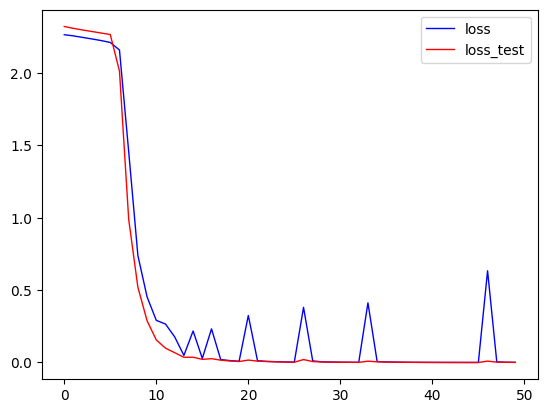

In [16]:
plt.plot(epoch_list, loss_train_list, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, loss_test_list, linewidth=1, color="red",label="loss_test")
plt.legend()

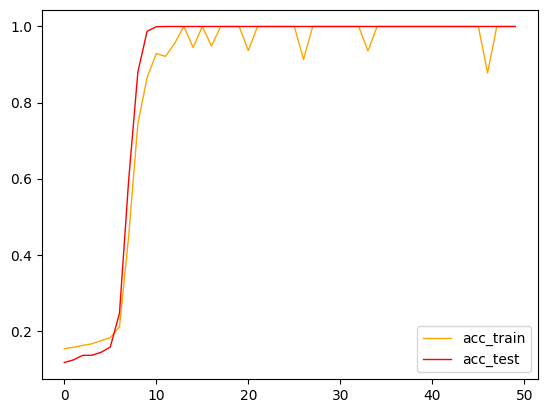

In [17]:
plt.plot(epoch_list, acc_train_list, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_list, acc_test_list, linewidth=1, color="red",label="acc_test")
plt.legend()

In [18]:
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
epoch_list = []
model = train(input_length=15, max_epochs=50, eval_freq=1)

start training RNN...
cuda:0


  2%|▏         | 1/50 [00:01<01:28,  1.82s/it]

TRAIN epoch: 0, loss : 2.265900, ACC: 0.156791
TEST epoch: 0, loss : 2.312315, ACC: 0.115331


  4%|▍         | 2/50 [00:03<01:27,  1.83s/it]

TRAIN epoch: 1, loss : 2.255950, ACC: 0.164604
TEST epoch: 1, loss : 2.302198, ACC: 0.126470


  6%|▌         | 3/50 [00:05<01:25,  1.82s/it]

TRAIN epoch: 2, loss : 2.247053, ACC: 0.168317
TEST epoch: 2, loss : 2.295003, ACC: 0.130647


  8%|▊         | 4/50 [00:07<01:23,  1.80s/it]

TRAIN epoch: 3, loss : 2.237535, ACC: 0.174660
TEST epoch: 3, loss : 2.286592, ACC: 0.137376


 10%|█         | 5/50 [00:09<01:22,  1.83s/it]

TRAIN epoch: 4, loss : 2.225572, ACC: 0.182008
TEST epoch: 4, loss : 2.277632, ACC: 0.144415


 12%|█▏        | 6/50 [00:10<01:18,  1.79s/it]

TRAIN epoch: 5, loss : 2.211012, ACC: 0.194462
TEST epoch: 5, loss : 2.270351, ACC: 0.150449


 14%|█▍        | 7/50 [00:12<01:17,  1.79s/it]

TRAIN epoch: 6, loss : 2.194503, ACC: 0.202816
TEST epoch: 6, loss : 2.263232, ACC: 0.158029


 16%|█▌        | 8/50 [00:14<01:15,  1.79s/it]

TRAIN epoch: 7, loss : 2.174341, ACC: 0.211324
TEST epoch: 7, loss : 2.260462, ACC: 0.156095


 18%|█▊        | 9/50 [00:16<01:13,  1.80s/it]

TRAIN epoch: 8, loss : 2.009109, ACC: 0.263537
TEST epoch: 8, loss : 1.551505, ACC: 0.418472


 20%|██        | 10/50 [00:18<01:11,  1.79s/it]

TRAIN epoch: 9, loss : 1.220731, ACC: 0.515625
TEST epoch: 9, loss : 1.253519, ACC: 0.437577


 22%|██▏       | 11/50 [00:19<01:10,  1.81s/it]

TRAIN epoch: 10, loss : 0.791558, ACC: 0.710705
TEST epoch: 10, loss : 0.622795, ACC: 0.754796


 24%|██▍       | 12/50 [00:21<01:08,  1.80s/it]

TRAIN epoch: 11, loss : 0.553082, ACC: 0.786665
TEST epoch: 11, loss : 0.515475, ACC: 0.705600


 26%|██▌       | 13/50 [00:23<01:06,  1.80s/it]

TRAIN epoch: 12, loss : 0.411051, ACC: 0.864867
TEST epoch: 12, loss : 0.681329, ACC: 0.588954


 28%|██▊       | 14/50 [00:25<01:05,  1.82s/it]

TRAIN epoch: 13, loss : 0.326237, ACC: 0.906869
TEST epoch: 13, loss : 0.163312, ACC: 0.997834


 30%|███       | 15/50 [00:27<01:03,  1.82s/it]

TRAIN epoch: 14, loss : 0.249699, ACC: 0.926129
TEST epoch: 14, loss : 0.108097, ACC: 0.999613


 32%|███▏      | 16/50 [00:29<01:02,  1.83s/it]

TRAIN epoch: 15, loss : 0.190372, ACC: 0.952661
TEST epoch: 15, loss : 0.071015, ACC: 0.999691


 34%|███▍      | 17/50 [00:30<01:00,  1.84s/it]

TRAIN epoch: 16, loss : 0.169720, ACC: 0.956838
TEST epoch: 16, loss : 0.049719, ACC: 1.000000


 36%|███▌      | 18/50 [00:32<00:58,  1.83s/it]

TRAIN epoch: 17, loss : 0.035015, ACC: 1.000000
TEST epoch: 17, loss : 0.033804, ACC: 0.999691


 38%|███▊      | 19/50 [00:34<00:57,  1.85s/it]

TRAIN epoch: 18, loss : 0.293006, ACC: 0.938892
TEST epoch: 18, loss : 0.030883, ACC: 1.000000


 40%|████      | 20/50 [00:36<00:55,  1.84s/it]

TRAIN epoch: 19, loss : 0.023872, ACC: 1.000000
TEST epoch: 19, loss : 0.019568, ACC: 1.000000


 42%|████▏     | 21/50 [00:38<00:52,  1.82s/it]

TRAIN epoch: 20, loss : 0.015319, ACC: 1.000000
TEST epoch: 20, loss : 0.012280, ACC: 1.000000


 44%|████▍     | 22/50 [00:39<00:51,  1.83s/it]

TRAIN epoch: 21, loss : 0.401116, ACC: 0.915532
TEST epoch: 21, loss : 0.091066, ACC: 0.991569


 46%|████▌     | 23/50 [00:41<00:49,  1.83s/it]

TRAIN epoch: 22, loss : 0.087983, ACC: 0.980894
TEST epoch: 22, loss : 0.019401, ACC: 1.000000


 48%|████▊     | 24/50 [00:43<00:47,  1.82s/it]

TRAIN epoch: 23, loss : 0.014508, ACC: 1.000000
TEST epoch: 23, loss : 0.011465, ACC: 1.000000


 50%|█████     | 25/50 [00:45<00:45,  1.81s/it]

TRAIN epoch: 24, loss : 0.009148, ACC: 1.000000
TEST epoch: 24, loss : 0.007586, ACC: 1.000000


 52%|█████▏    | 26/50 [00:47<00:43,  1.80s/it]

TRAIN epoch: 25, loss : 0.006070, ACC: 1.000000
TEST epoch: 25, loss : 0.004963, ACC: 1.000000


 54%|█████▍    | 27/50 [00:49<00:41,  1.82s/it]

TRAIN epoch: 26, loss : 0.483398, ACC: 0.887608
TEST epoch: 26, loss : 0.151169, ACC: 0.989712


 56%|█████▌    | 28/50 [00:50<00:39,  1.81s/it]

TRAIN epoch: 27, loss : 0.032976, ACC: 0.999613
TEST epoch: 27, loss : 0.012547, ACC: 1.000000


 58%|█████▊    | 29/50 [00:52<00:38,  1.82s/it]

TRAIN epoch: 28, loss : 0.008949, ACC: 1.000000
TEST epoch: 28, loss : 0.006569, ACC: 1.000000


 60%|██████    | 30/50 [00:54<00:36,  1.82s/it]

TRAIN epoch: 29, loss : 0.005345, ACC: 1.000000
TEST epoch: 29, loss : 0.004419, ACC: 1.000000


 62%|██████▏   | 31/50 [00:56<00:34,  1.81s/it]

TRAIN epoch: 30, loss : 0.003706, ACC: 1.000000
TEST epoch: 30, loss : 0.003108, ACC: 1.000000


 64%|██████▍   | 32/50 [00:58<00:32,  1.81s/it]

TRAIN epoch: 31, loss : 0.002582, ACC: 1.000000
TEST epoch: 31, loss : 0.002137, ACC: 1.000000


 66%|██████▌   | 33/50 [00:59<00:30,  1.81s/it]

TRAIN epoch: 32, loss : 0.001743, ACC: 1.000000
TEST epoch: 32, loss : 0.001415, ACC: 1.000000


 68%|██████▊   | 34/50 [01:01<00:29,  1.82s/it]

TRAIN epoch: 33, loss : 0.537036, ACC: 0.865022
TEST epoch: 33, loss : 0.259296, ACC: 0.874226


 70%|███████   | 35/50 [01:03<00:27,  1.82s/it]

TRAIN epoch: 34, loss : 0.233711, ACC: 0.908416
TEST epoch: 34, loss : 0.021002, ACC: 1.000000


 72%|███████▏  | 36/50 [01:05<00:25,  1.81s/it]

TRAIN epoch: 35, loss : 0.011252, ACC: 1.000000
TEST epoch: 35, loss : 0.006527, ACC: 1.000000


 74%|███████▍  | 37/50 [01:07<00:23,  1.81s/it]

TRAIN epoch: 36, loss : 0.004550, ACC: 1.000000
TEST epoch: 36, loss : 0.003148, ACC: 1.000000


 76%|███████▌  | 38/50 [01:08<00:21,  1.80s/it]

TRAIN epoch: 37, loss : 0.002424, ACC: 1.000000
TEST epoch: 37, loss : 0.001896, ACC: 1.000000


 78%|███████▊  | 39/50 [01:10<00:19,  1.80s/it]

TRAIN epoch: 38, loss : 0.001538, ACC: 1.000000
TEST epoch: 38, loss : 0.001279, ACC: 1.000000


 80%|████████  | 40/50 [01:12<00:17,  1.79s/it]

TRAIN epoch: 39, loss : 0.001079, ACC: 1.000000
TEST epoch: 39, loss : 0.000926, ACC: 1.000000


 82%|████████▏ | 41/50 [01:14<00:16,  1.81s/it]

TRAIN epoch: 40, loss : 0.000779, ACC: 1.000000
TEST epoch: 40, loss : 0.000664, ACC: 1.000000


 84%|████████▍ | 42/50 [01:16<00:14,  1.79s/it]

TRAIN epoch: 41, loss : 0.000550, ACC: 1.000000
TEST epoch: 41, loss : 0.000462, ACC: 1.000000


 86%|████████▌ | 43/50 [01:17<00:12,  1.78s/it]

TRAIN epoch: 42, loss : 0.432295, ACC: 0.929223
TEST epoch: 42, loss : 0.007631, ACC: 1.000000


 88%|████████▊ | 44/50 [01:19<00:10,  1.80s/it]

TRAIN epoch: 43, loss : 0.004950, ACC: 1.000000
TEST epoch: 43, loss : 0.003360, ACC: 1.000000


 90%|█████████ | 45/50 [01:21<00:08,  1.79s/it]

TRAIN epoch: 44, loss : 0.002497, ACC: 1.000000
TEST epoch: 44, loss : 0.001871, ACC: 1.000000


 92%|█████████▏| 46/50 [01:23<00:07,  1.79s/it]

TRAIN epoch: 45, loss : 0.001499, ACC: 1.000000
TEST epoch: 45, loss : 0.001217, ACC: 1.000000


 94%|█████████▍| 47/50 [01:25<00:05,  1.81s/it]

TRAIN epoch: 46, loss : 0.001019, ACC: 1.000000
TEST epoch: 46, loss : 0.000857, ACC: 1.000000


 96%|█████████▌| 48/50 [01:27<00:03,  1.82s/it]

TRAIN epoch: 47, loss : 0.000726, ACC: 1.000000
TEST epoch: 47, loss : 0.000620, ACC: 1.000000


 98%|█████████▊| 49/50 [01:28<00:01,  1.84s/it]

TRAIN epoch: 48, loss : 0.000526, ACC: 1.000000
TEST epoch: 48, loss : 0.000454, ACC: 1.000000


100%|██████████| 50/50 [01:30<00:00,  1.81s/it]

TRAIN epoch: 49, loss : 0.000382, ACC: 1.000000
TEST epoch: 49, loss : 0.000330, ACC: 1.000000


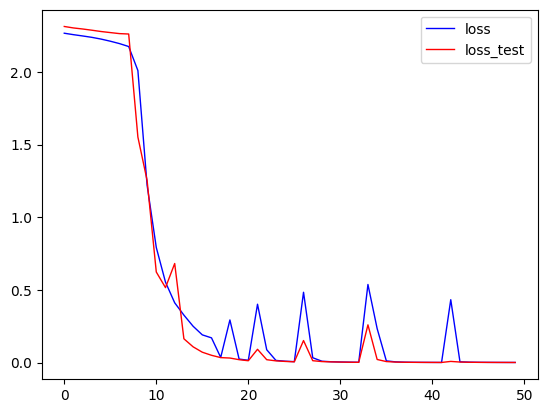

In [19]:
plt.plot(epoch_list, loss_train_list, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, loss_test_list, linewidth=1, color="red",label="loss_test")
plt.legend()

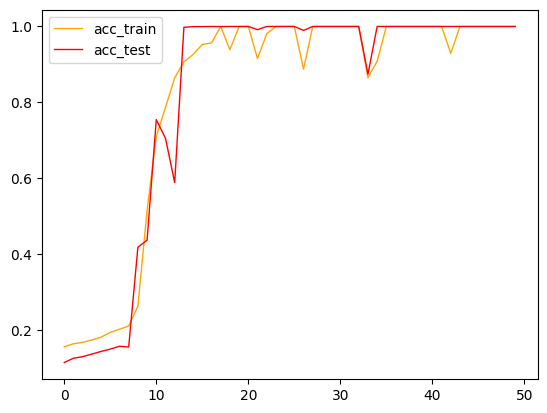

In [20]:
plt.plot(epoch_list, acc_train_list, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_list, acc_test_list, linewidth=1, color="red",label="acc_test")
plt.legend()